# Why Resnet50

**Strong Feature Extraction:** ResNet-50’s deep architecture captures intricate details in signatures, such as stroke patterns, texture, and pressure variations, essential for distinguishing real and forged signatures.

**Residual Connections:** Its residual blocks allow effective training of a deep network, ensuring good performance even on small or complex datasets by mitigating vanishing gradient issues.

**Adaptability:** It can be fine-tuned to focus on signature-specific features, making it suitable for tasks requiring high precision like signature verification.

**Efficiency and Scalability:** ResNet-50 balances depth and computational efficiency, making it practical for deployment in real-world signature verification systems.

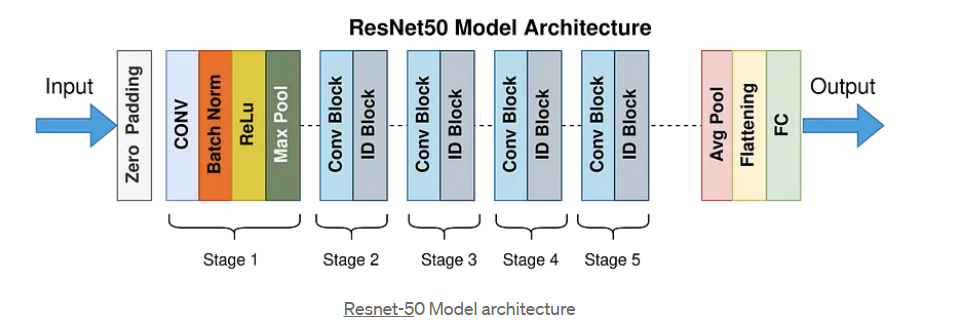
https://commons.wikimedia.org/wiki/File:ResNet50.png

# Imports

In [ ]:
import kagglehub
import os
import cv2
import random
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# load data

### helper function

In [ ]:
def load_images(folder_path, folder_type, target_size=(128, 128), sample_count=5):
    images = []
    labels = []
    all_filenames = []
    sample_images = []
    sample_labels = []  

    if not os.path.isdir(folder_path):
        print(f"Warning: Folder {folder_path} does not exist.")
        return np.array(images), np.array(labels), all_filenames

    print(f"Loading images from subfolders of: {folder_path}")

    for root, _, files in os.walk(folder_path):
        for filename in files:
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(root, filename)
                try:
                    img = load_img(img_path, target_size=target_size)
                    img = img_to_array(img)
                    img = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2GRAY)
                    img_array = img / 255.0
                    img_array = np.expand_dims(img_array, axis=-1)

                    if len(sample_images) < sample_count:
                        sample_images.append(img_array)
                        sample_labels.append('Real' if folder_type.lower() == 'real' else 'Forged')

                    images.append(img_array)
                    labels.append(1 if folder_type.lower() == 'real' else 0)
                    all_filenames.append(img_path)
                except Exception as e:
                    print(f"Error processing file {img_path}: {e}")

    if sample_images:
        fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 5))
        for ax, sample_img, sample_label in zip(axes, sample_images, sample_labels):
            ax.imshow(sample_img.squeeze(), cmap='gray')
            ax.set_title(sample_label, fontsize=10)  # Use label instead of filename
            ax.axis('off')
        plt.tight_layout()
        plt.show()

    print(f"Total images loaded: {len(images)}")
    return np.array(images), np.array(labels), all_filenames


### loading and plotting

In [ ]:
path = kagglehub.dataset_download("tienen/handwritten-signature-verification")

In [ ]:
f_data = "/kaggle/input/handwritten-signature-verification/data/data/forged"
r_data = "/kaggle/input/handwritten-signature-verification/data/data/real"

In [ ]:
imgs_f, labels_f, k = load_images(f_data, "forged")
imgs_r, labels_r, l = load_images(r_data, "real")

# prepocessing

In [ ]:
all_images = np.concatenate((imgs_f, imgs_r), axis=0)
all_labels = np.concatenate((labels_f, labels_r), axis=0)


all_images, all_labels = shuffle(all_images, all_labels, random_state=42)

In [ ]:
all_labels = to_categorical(all_labels,num_classes = 2)

In [ ]:
all_labels.shape

In [ ]:
all_images.shape

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.3, random_state=42)

In [ ]:
print(x_train.shape)
x_test.shape

### data augmentation

In [ ]:
train_datagen = ImageDataGenerator(       
    rotation_range=35,               
    width_shift_range=0.3,           
    height_shift_range=0.2,          
    shear_range=0.3,                 
    horizontal_flip=True,                    
)


train_generator = train_datagen.flow(x_train, y_train, batch_size=128) 

# Model 

## helper functions

In [ ]:
def plot_train(hist):
    history = hist.history

    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    axes[0].plot(history['loss'], label='Training Loss')
    axes[0].plot(history['val_loss'], label='Validation Loss')
    axes[0].set_title('Model Loss Over Epochs')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid()

    if 'accuracy' in history:  # Adjust for older versions with 'acc'
        axes[1].plot(history['accuracy'], label='Training Accuracy')
        axes[1].plot(history['val_accuracy'], label='Validation Accuracy')
        axes[1].set_title('Model Accuracy Over Epochs')
        axes[1].set_xlabel('Epochs')
        axes[1].set_ylabel('Accuracy')
        axes[1].legend()
        axes[1].grid()


    plt.tight_layout()
    plt.show()

## creation

In [ ]:
base_model = ResNet50(include_top=False, weights=None, input_shape=(128, 128, 1))

for layer in base_model.layers[:30]:
    layer.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)  
x = Dense(128, activation='relu',kernel_regularizer= tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu',kernel_regularizer= tf.keras.regularizers.l2(0.01))(x)
predictions = Dense(2, activation='softmax')(x)  

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

## training

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=(x_test,y_test),
    epochs=25,
    callbacks=[early_stopping],
    batch_size = 128
)

In [ ]:
plot_train(history)

In [ ]:
for layer in base_model.layers[-30:]:  
    layer.trainable = True

# Recompile the model after unfreezing
model.compile(optimizer=Adam(learning_rate=0.00001),  # Lower learning rate for fine-tuning
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_tuned = model.fit(
    train_generator,
    validation_data=(x_test,y_test),
    epochs=100,
    callbacks=[early_stopping],
    batch_size = 128
)

In [ ]:
plot_train(history_tuned)

In [ ]:
# creating more complex augemtation to prevent over fitting
train_datagen = ImageDataGenerator(       
    rotation_range=35,               
    width_shift_range=0.3,           
    height_shift_range=0.3,          
    shear_range=0.4,                 
    horizontal_flip=True,                    
)


train_generator = train_datagen.flow(x_train, y_train, batch_size=64) 

In [ ]:
for layer in base_model.layers[-30:]:  
    layer.trainable = True

# Recompile the model after unfreezing
model.compile(optimizer=Adam(learning_rate=0.00001),  # Lower learning rate for fine-tuning
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model with early stopping
history_tuned = model.fit(
    train_generator,
    validation_data=(x_test,y_test),
    epochs=100,
    callbacks=[early_stopping],
    batch_size = 64
)

In [ ]:
plot_train(history_tuned)

## testing

In [ ]:
model.evaluate(x_test,y_test)

## save model

In [ ]:
model.save('fr.h5')
from IPython.display import FileLink
FileLink('fr.h5')